In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
from constants import *
from plot_config import *
from sample_analysis import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [68]:
# Failure times loading parameters
N_SAMPLES = 5
N_SEGMENTS = 6
start_id = 60
stop_id = start_id + N_SAMPLES
IDS = np.arange(start_id, stop_id)
FILE_NAMES = [f'id=00{str(id)}.h5' for id in IDS]

In [69]:
SIGMA = 3.5  # Sets the timescale of avalanches
TAU = 1.27  # Exponent of the power-law distribution of avalanche sizes

In [70]:
COMPUTE_ACTIVITY_FOR_RANDOM_MICROSCOPIC_EVENT = True
COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS = True
COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS = True

THRESHOLD = 1

# Number of peaks to consider when randomly selecting peaks
RANDOM_SEED = 0
N_RANDOM_PEAKS = 20000

# Number of time windows to consider when counting events
T = 100
T_START = 1e-10
T_END = 1

# Number of peak heights to consider when filtering peaks
N_H = 6
START_STD_H = 4
END_STD_H = 9
VAR_H = 0.05

In [71]:
all_failure_times, _ = load_failure_data(filenames=FILE_NAMES,
                                         directory=FAILURE_DATA_DIR,
                                         loading_segments=N_SEGMENTS,
                                         verbose=False)

for failure_times in all_failure_times:
    failure_times /= TAU_ALPHA

100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


In [73]:
all_heights_stats = all_sample_heights_stats(all_failure_times=all_failure_times,
                                             sigma=SIGMA,
                                             threshold=THRESHOLD,
                                             save=False,
                                             filename=f"heights_{start_id}-{stop_id - 1}_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}.pkl")

MEAN_H = all_heights_stats['mean_all_h']
STD_H = all_heights_stats['std_all_h']
all_peak_heights = all_heights_stats['all_peak_h']

print(f"Number of peaks across {N_SAMPLES} samples: {len(all_peak_heights)}")
print(f"Mean height: {MEAN_H}")
print(f"Std height: {STD_H}")

N_STD = np.linspace(START_STD_H, END_STD_H, N_H)
HEIGHTS = MEAN_H + N_STD * STD_H
print(f"Peak heights: {HEIGHTS}")

Computing heights:   0%|          | 0/5 [01:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fit = powerlaw.Fit(all_peak_heights, xmin=min(all_peak_heights), xmax=max(all_peak_heights), discrete=True)
print(f"Exponent: {fit.alpha}")
print(f"Error: {fit.sigma}")

In [ ]:
height_bin_infos = {
    'mean_h': MEAN_H,
    'std_h': STD_H,
    'n_std': N_STD,
    'heights': HEIGHTS,
}

HEIGHTS_dir = os.path.join(SAVE_DIR, "sample_data/heights_info")
if not os.path.exists(HEIGHTS_dir):
    os.makedirs(HEIGHTS_dir)
save_path = os.path.join(HEIGHTS_dir,
                         f"HEIGHTS_{start_id}-{stop_id - 1}_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}.pkl")
with open(save_path, 'wb') as f:
    pickle.dump(height_bin_infos, f)

In [ ]:
output_dicts = []
for i, failure_times in enumerate(all_failure_times):
    print(f"SAMPLE {i + 1}")
    output_dicts.append(
        sample_analysis(times=failure_times,
                        sigma=SIGMA,
                        threshold=THRESHOLD,
                        compute_activity_for_random_heights=COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS,
                        compute_activity_for_given_heights=COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS,
                        n_random_peaks=N_RANDOM_PEAKS,
                        heights=HEIGHTS,
                        var_h=VAR_H,
                        t_start=T_START,
                        t_stop=T_END,
                        num_time_windows=T,
                        save=True,
                        filename=f"sample_{IDS[i]}_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}_{N_RANDOM_PEAKS}rpeak_T{T}.pkl", )
    )
    print(f"{50 * '='}\n")

In [ ]:
if COMPUTE_ACTIVITY_FOR_RANDOM_MICROSCOPIC_EVENT: 
    n_events_around_micro_event_dict = n_events_around_microscopic_event(all_failure_times, 
                                                                         N_random_peaks=N_RANDOM_PEAKS, 
                                                                         t_start=T_START, 
                                                                         t_stop=T_END, 
                                                                         num_time_windows=T, 
                                                                         save=False, 
                                                                         filename=f"micro_event_{N_SAMPLES}samples_{N_SEGMENTS}seg_sigma{SIGMA}_threshold{THRESHOLD}_T{T}.pkl")
    print("Number of sampled peaks: ", len(n_events_around_micro_event_dict['n_before']))

In [ ]:
if COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS:
    random_time_windows = output_dicts[0]['random_time_windows']

    all_random_n_before = np.concatenate([output_dicts[i]['random_n_before'] for i in range(N_SAMPLES)], axis=0)
    mean_random_n_before = np.mean(all_random_n_before, axis=0)
    std_random_n_before = np.std(all_random_n_before, axis=0, ddof=1)

    all_random_n_after = np.concatenate([output_dicts[i]['random_n_after'] for i in range(N_SAMPLES)], axis=0)
    mean_random_n_after = np.mean(all_random_n_after, axis=0)
    std_random_n_after = np.std(all_random_n_after, axis=0, ddof=1)

    all_random_n_peaks = np.sum([output_dicts[i]['n_random_peaks'] for i in range(N_SAMPLES)], axis=0)

    random_activity_before = all_random_n_before / random_time_windows
    mean_random_activity_before = np.mean(random_activity_before, axis=0)
    std_random_activity_before = np.std(random_activity_before, axis=0, ddof=1)

    random_activity_after = all_random_n_after / random_time_windows
    mean_random_activity_after = np.mean(random_activity_after, axis=0)
    std_random_activity_after = np.std(random_activity_after, axis=0, ddof=1)

In [12]:
# Concatenate across samples for the same peak height
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    time_windows = output_dicts[0]['time_windows']

    all_n_before = [output_dicts[i]['n_before'] for i in range(N_SAMPLES)]
    all_n_before = concatenate_result(all_n_before, HEIGHTS, N_SAMPLES)
    mean_n_before = {h: np.mean(all_n_before[h], axis=0) for h in HEIGHTS}
    std_n_before = {h: np.std(all_n_before[h], axis=0, ddof=1) for h in HEIGHTS}

    all_n_after = [output_dicts[i]['n_after'] for i in range(N_SAMPLES)]
    all_n_after = concatenate_result(all_n_after, HEIGHTS, N_SAMPLES)
    mean_n_after = {h: np.mean(all_n_after[h], axis=0) for h in HEIGHTS}
    std_n_after = {h: np.std(all_n_after[h], axis=0, ddof=1) for h in HEIGHTS}

    all_n_peaks = [output_dicts[i]['n_peaks'] for i in range(N_SAMPLES)]
    all_n_peaks = {h: np.sum([all_n_peaks[i][h] for i in range(N_SAMPLES)]) for h in HEIGHTS}

    activity_before = {h: all_n_before[h] / time_windows for h in HEIGHTS}
    mean_activity_before = {h: np.mean(activity_before[h], axis=0) for h in HEIGHTS}
    std_activity_before = {h: np.std(activity_before[h], axis=0, ddof=1) for h in HEIGHTS}

    activity_after = {h: all_n_after[h] / time_windows for h in HEIGHTS}
    mean_activity_after = {h: np.mean(activity_after[h], axis=0) for h in HEIGHTS}
    std_activity_after = {h: np.std(activity_after[h], axis=0, ddof=1) for h in HEIGHTS}

    normalized_mean_activity_before = {h: mean_activity_before[h] / mean_activity_before[h][0] for h in HEIGHTS}
    normalized_mean_activity_after = {h: mean_activity_after[h] / mean_activity_after[h][0] for h in HEIGHTS}

# Distribution of Peak Heights

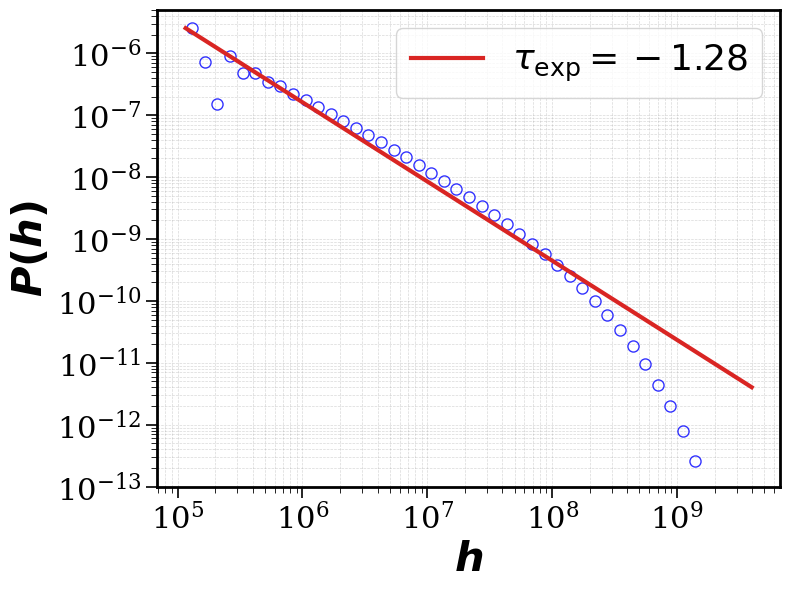

In [13]:
c_red = plt.get_cmap('Reds')
c_blue = plt.get_cmap('Blues')
c = ['blue', c_red(0.7)]
fig, ax = plt.subplots(figsize=(8, 6))
fit.plot_pdf(color=c[0], marker='o', linestyle='None', fillstyle='none', ax=ax, markersize=8, alpha=0.8)
fit.power_law.plot_pdf(color=c[1], linestyle='-', ax=ax , label=rf'$\tau_{{\rm exp}}=-{fit.alpha:.2f}$', linewidth=3)
ax.set_xlabel(r'$\boldsymbol{h}$')
ax.set_ylabel(r'$\boldsymbol{P(h)}$')
ax.legend()
plt.grid(True, alpha=0.3, linestyle='--', which='both')
plt.ylim(1e-13, 5e-6)
plt.tight_layout()

if SAVE_PLOT:
    save_dir = os.path.join(FIGURE_DIR)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'heights_pdf.pdf'), bbox_inches='tight')
    with open(os.path.join(save_dir, 'heights_pdf.pkl'), 'wb') as f:
        pickle.dump(fig, f)

plt.show()

# Activity for Random Microscopic Event

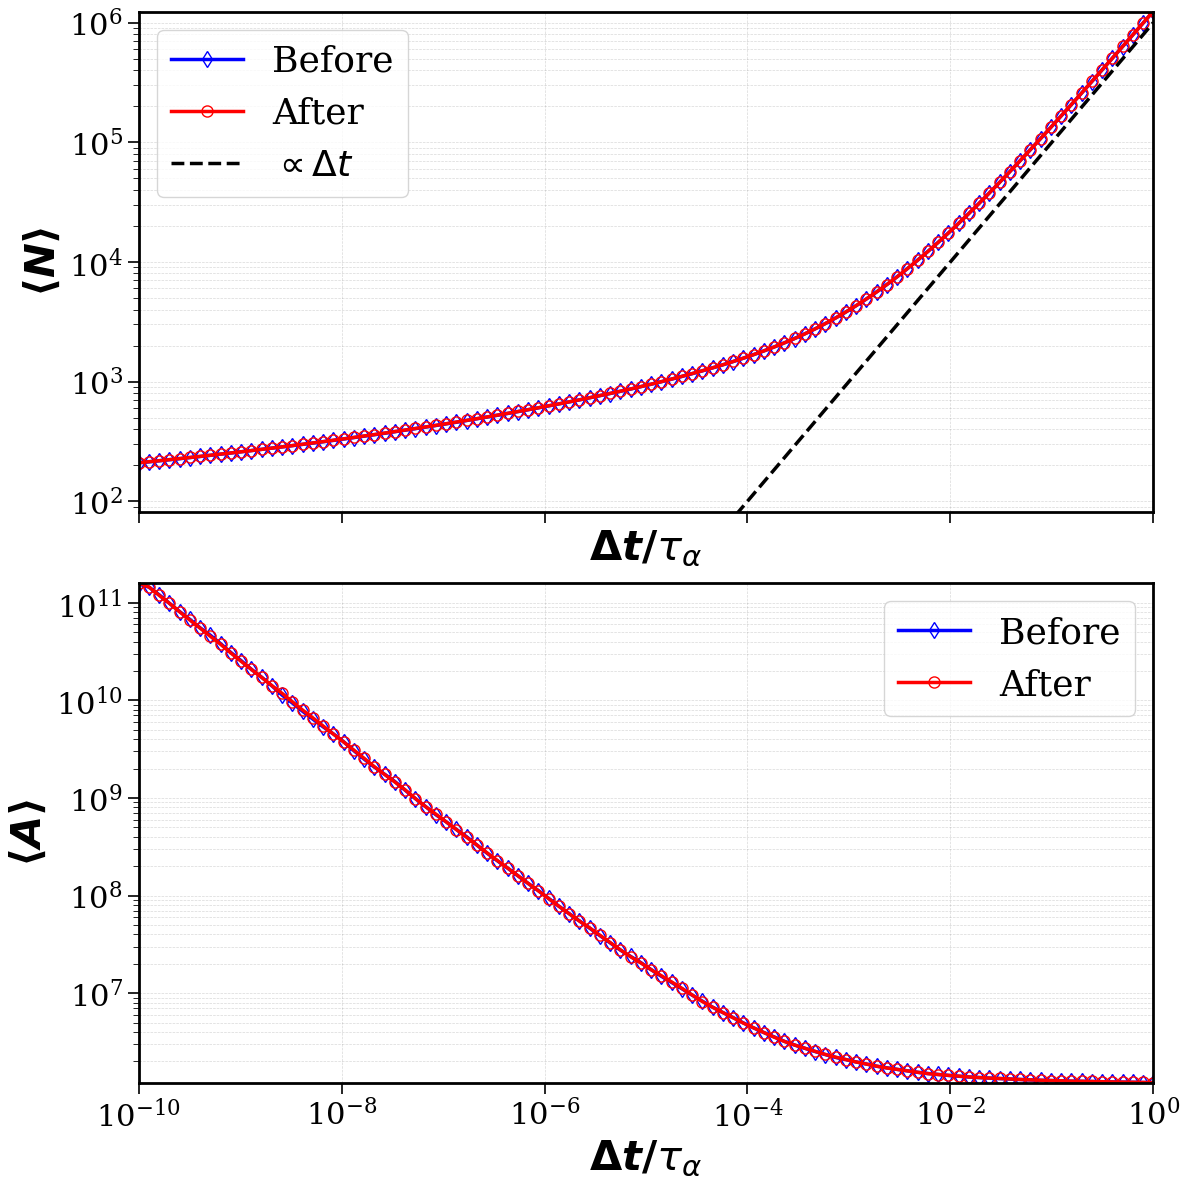

In [49]:
if COMPUTE_ACTIVITY_FOR_RANDOM_MICROSCOPIC_EVENT:
    micro_time_windows = n_events_around_micro_event_dict['time_windows']
    mean_n_micro_before = n_events_around_micro_event_dict['mean_n_before']
    mean_n_micro_after = n_events_around_micro_event_dict['mean_n_after']
    std_n_micro_before = n_events_around_micro_event_dict['std_n_before']
    std_n_micro_after = n_events_around_micro_event_dict['std_n_after']

    mean_a_micro_before = np.gradient(mean_n_micro_before, micro_time_windows)
    mean_a_micro_after = np.gradient(mean_n_micro_after, micro_time_windows)
    
    median_n_micro_before = np.median(n_events_around_micro_event_dict['n_before'], axis=0)
    median_n_micro_after = np.median(n_events_around_micro_event_dict['n_after'], axis=0)
    
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
    axs[0].plot(micro_time_windows, mean_n_micro_before, marker='d', fillstyle='none', linestyle='-', color='b', label='Before', markersize=8)
    # axs[0].fill_between(micro_time_windows, mean_n_micro_before - std_n_micro_before, mean_n_micro_before + std_n_micro_before, color='b', alpha=0.25)
    
    axs[0].plot(micro_time_windows, mean_n_micro_after, marker='o', fillstyle='none', linestyle='-', color='r', label='After', markersize=8)
    # axs[0].fill_between(micro_time_windows, mean_n_micro_after - std_n_micro_after, mean_n_micro_after + std_n_micro_after, color='r', alpha=0.25)
    
    axs[0].plot(micro_time_windows, 1e6 * micro_time_windows, linestyle='--', color='black', label=r'$\propto \Delta t$')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[0].set_ylabel(r'$\boldsymbol{\langle N \rangle}$')
    axs[0].set_xlim(min(micro_time_windows), max(micro_time_windows))
    axs[0].set_ylim(min([median_n_micro_before.min(), median_n_micro_after.min()]),
                    max([median_n_micro_before.max(), median_n_micro_after.max()]))
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')

    axs[1].plot(micro_time_windows, mean_a_micro_before,marker='d', fillstyle='none', linestyle='-', color='b', label='Before', markersize=8)
    axs[1].plot(micro_time_windows, mean_a_micro_after, marker='o',   fillstyle='none', linestyle='-', color='r', label='After', markersize=8)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle A \rangle}$')
    axs[1].set_xlim(min(micro_time_windows), max(micro_time_windows))
    axs[1].set_ylim(min([mean_a_micro_before.min(), mean_a_micro_after.min()]),
                    max([mean_a_micro_before.max(), mean_a_micro_after.max()]))
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')

    plt.tight_layout()

    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'activity_vs_time_random.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'activity_vs_time_random.pkl'), 'wb') as f:
            pickle.dump(fig, f)

    plt.show()

# Mean Activity for Random Peak Heights

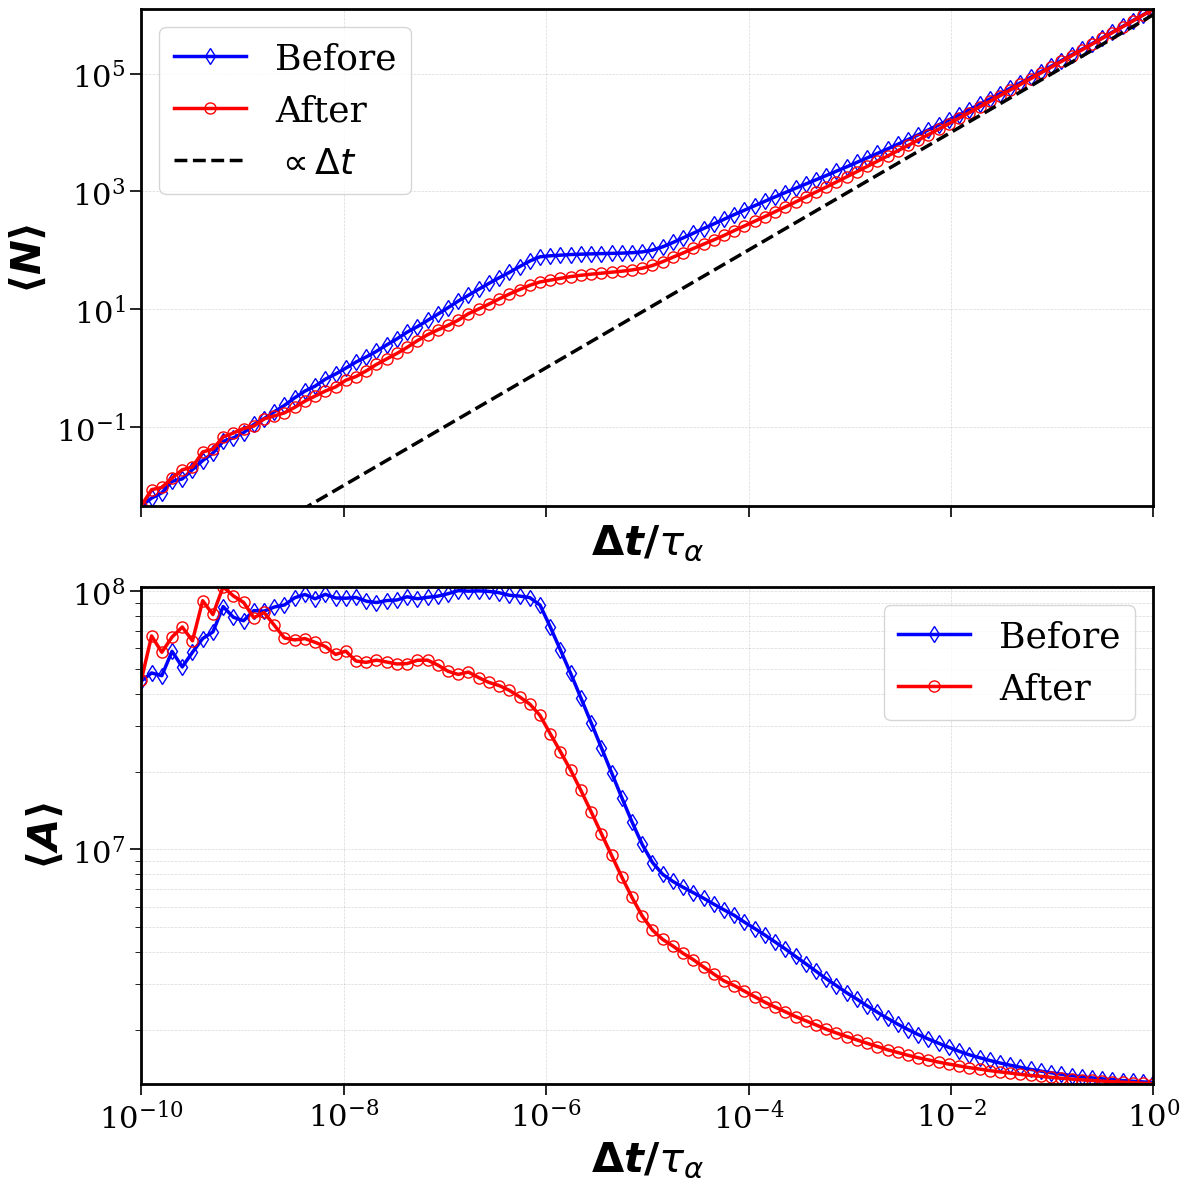

In [20]:
if COMPUTE_ACTIVITY_FOR_RANDOM_HEIGHTS:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
    axs[0].plot(random_time_windows, mean_random_n_before, marker='d', fillstyle='none', linestyle='-', color='b', label='Before', markersize=8)
    axs[0].plot(random_time_windows, mean_random_n_after, marker='o', fillstyle='none', linestyle='-', color='r', label='After', markersize=8)
    axs[0].plot(random_time_windows, 1e6 * random_time_windows, linestyle='--', color='black',
                label=r'$\propto \Delta t$')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[0].set_ylabel(r'$\boldsymbol{\langle N \rangle}$')
    axs[0].set_xlim(min(random_time_windows), max(random_time_windows))
    axs[0].set_ylim(min([mean_random_n_before.min(), mean_random_n_after.min()]),
                    max([mean_random_n_before.max(), mean_random_n_after.max()]))
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')



    axs[1].plot(random_time_windows, mean_random_activity_before,marker='d', fillstyle='none', linestyle='-', color='b', label='Before', markersize=8)
    axs[1].plot(random_time_windows, mean_random_activity_after, marker='o',   fillstyle='none', linestyle='-', color='r', label='After', markersize=8)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle A \rangle}$')
    axs[1].set_xlim(min(random_time_windows), max(random_time_windows))
    axs[1].set_ylim(min([mean_random_activity_before.min(), mean_random_activity_after.min()]),
                    max([mean_random_activity_before.max(), mean_random_activity_after.max()]))
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')

    plt.tight_layout()
    
    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'activity_vs_time_random2.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'activity_vs_time_random2.pkl'), 'wb') as f:
            pickle.dump(fig, f)
    
    plt.show()

# Mean Activity for Given Peak Heights

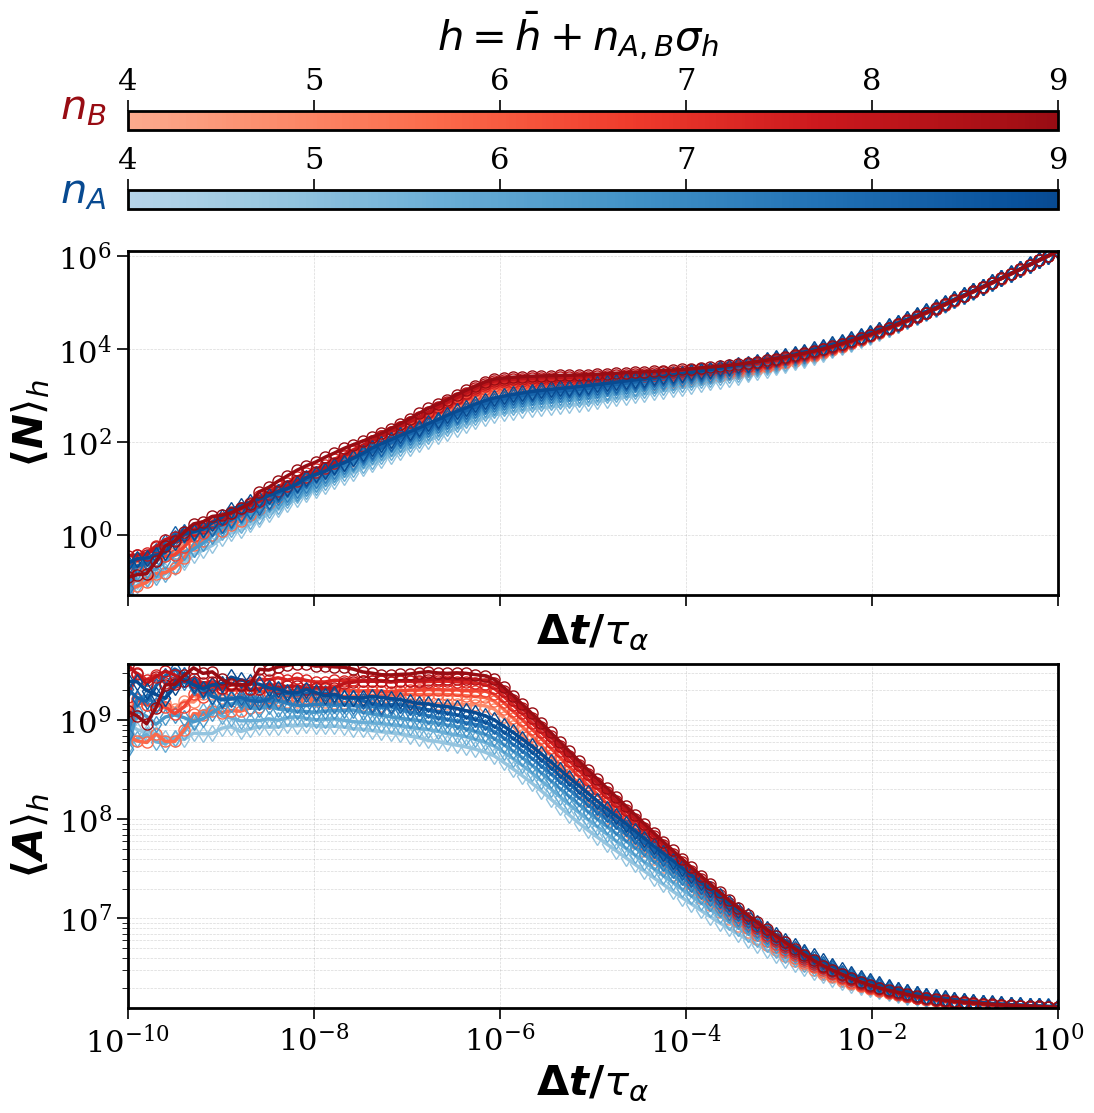

In [16]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Reds')
    colors_before = cmap_before(np.linspace(0.4, 0.9, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.4, 0.9, N_H))

    fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0].plot(time_windows, mean_n_after[h], linestyle='-', markersize=8,
                    marker=r'd', fillstyle='none', color=colors_after[i], label=rf'A: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[0].plot(time_windows, mean_n_before[h], linestyle='-', markersize=8, fillstyle='none',
                    marker='o', color=colors_before[i], label=rf'B: $h=\bar h+{n_std:.0f}\sigma_h$')
        axs[1].plot(time_windows, mean_activity_after[h], linestyle='-', marker=r'd', fillstyle='none',
                    color=colors_after[i], markersize=8)
        axs[1].plot(time_windows, mean_activity_before[h], linestyle='-', marker='o', fillstyle='none', color=colors_before[i],
                    markersize=8)

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[0].set_ylabel(r'$\boldsymbol{\langle N\rangle_h}$')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    axs[0].set_xlim(min(time_windows), max(time_windows))
    axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                    max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle A\rangle_h}$')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    axs[1].set_xlim(min(time_windows), max(time_windows))
    axs[1].set_ylim(
        min([mean_activity_before[h].min() for h in HEIGHTS] + [mean_activity_after[h].min() for h in HEIGHTS]),
        max([mean_activity_before[h].max() for h in HEIGHTS] + [mean_activity_after[h].max() for h in HEIGHTS]))

    # Create horizontal colorbars
    norm_before = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_before = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_before(np.linspace(0.3, 0.9, 256))), norm=norm_before)
    sm_before.set_array([])
    cbar_before = fig.colorbar(sm_before, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50,
                               location='top')

    norm_after = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_after = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_after(np.linspace(0.3, 0.9, 256))), norm=norm_after)
    sm_after.set_array([])
    cbar_after = fig.colorbar(sm_after, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, aspect=50,
                              location='top')

    # Add text annotations
    fig.text(0.088, 0.79, r'$n_A$', va='center', ha='center', rotation=0, fontsize=30, color=colors_after[-1])
    fig.text(0.088, 0.86, r'$n_B$', va='center', ha='center', rotation=0, fontsize=30, color=colors_before[-1])
    fig.text(0.5, 0.92, r'$h = \bar{h} + n_{A,B}\sigma_h$', va='center', ha='center', rotation=0, fontsize=30,
             color='black')

    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'activity_vs_time.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'activity_vs_time.pkl'), 'wb') as f:
            pickle.dump(fig, f)
    
    plt.show()

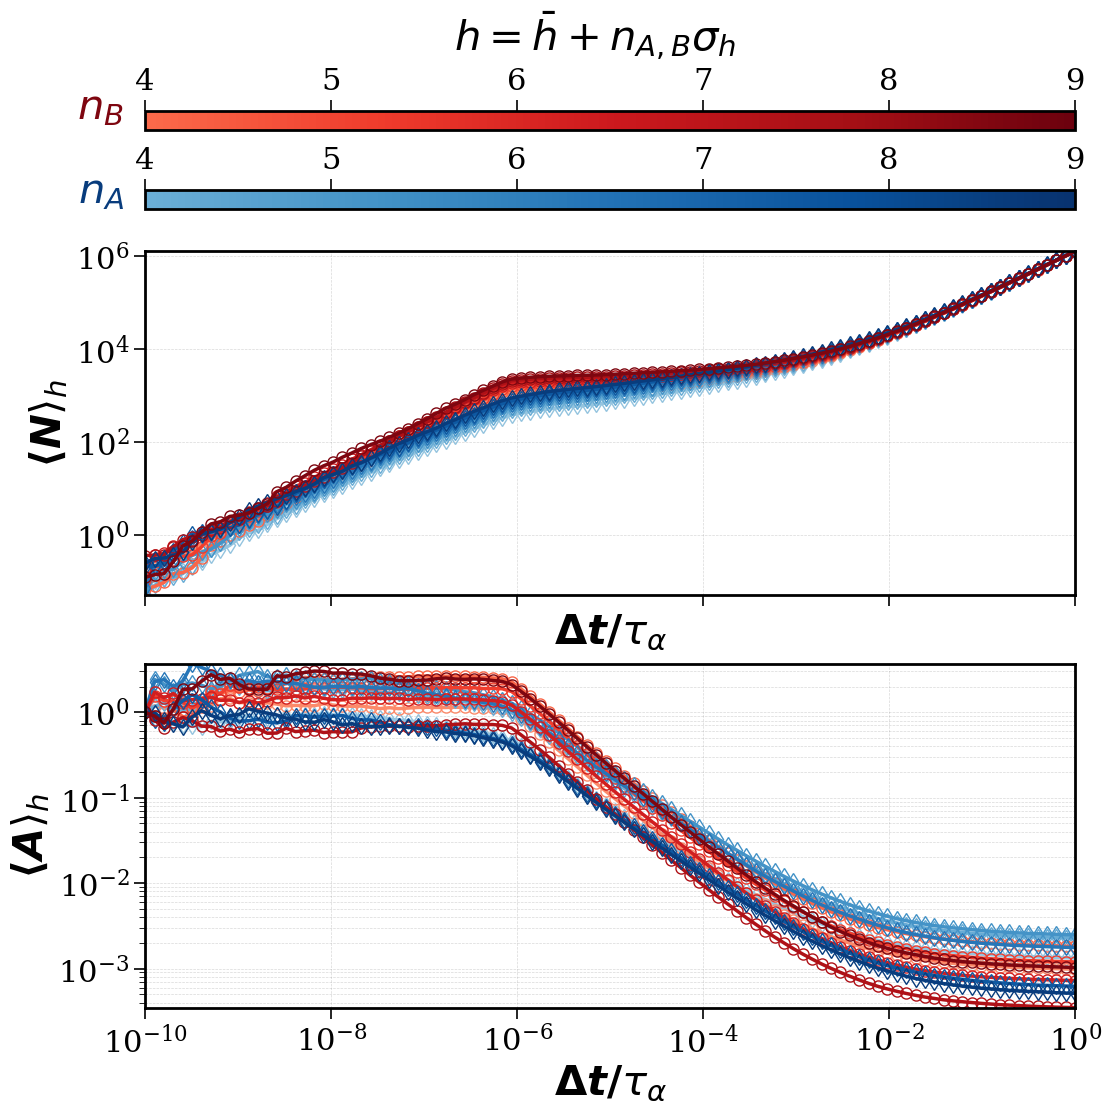

In [17]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Reds')
    colors_before = cmap_before(np.linspace(0.4, 0.95, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.4, 0.95, N_H))

    fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0].plot(time_windows, mean_n_after[h], linestyle='-', 
                    markersize=8, marker=r'd', fillstyle='none', 
                    color=colors_after[i], label=rf'A: $h=\bar h+{n_std:.0f}\sigma_h$')
        
        axs[0].plot(time_windows, mean_n_before[h], linestyle='-', 
                    markersize=8, fillstyle='none', marker='o', 
                    color=colors_before[i], label=rf'B: $h=\bar h+{n_std:.0f}\sigma_h$')
        
        axs[1].plot(time_windows, normalized_mean_activity_after[h], linestyle='-', 
                    marker=r'd', fillstyle='none', markersize=8,
                    color=colors_after[i])
        axs[1].plot(time_windows, normalized_mean_activity_before[h], linestyle='-', marker='o', fillstyle='none', color=colors_before[i],
                    markersize=8)

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[0].set_ylabel(r'$\boldsymbol{\langle N\rangle_h}$')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    axs[0].set_xlim(min(time_windows), max(time_windows))
    axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                    max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle A\rangle_h}$')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    axs[1].set_xlim(min(time_windows), max(time_windows))
    axs[1].set_ylim(
        min([normalized_mean_activity_before[h].min() for h in HEIGHTS] + [normalized_mean_activity_after[h].min() for h
                                                                           in HEIGHTS]),
        max([normalized_mean_activity_before[h].max() for h in HEIGHTS] + [normalized_mean_activity_after[h].max() for h
                                                                           in HEIGHTS]))
    
    # Create horizontal colorbars
    norm_before = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_before = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_before(np.linspace(0.5, 0.99, 256))), norm=norm_before)
    sm_before.set_array([])
    cbar_before = fig.colorbar(sm_before, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50,
                               location='top')

    norm_after = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_after = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_after(np.linspace(0.5, 0.99, 256))), norm=norm_after)
    sm_after.set_array([])
    cbar_after = fig.colorbar(sm_after, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, aspect=50,
                              location='top')

    # Add text annotations
    fig.text(0.088, 0.79, r'$n_A$', va='center', ha='center', rotation=0, fontsize=30, color=colors_after[-1])
    fig.text(0.088, 0.86, r'$n_B$', va='center', ha='center', rotation=0, fontsize=30, color=colors_before[-1])
    fig.text(0.5, 0.92, r'$h = \bar{h} + n_{A,B}\sigma_h$', va='center', ha='center', rotation=0, fontsize=30,
             color='black')
    
    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'norm_activity_vs_time.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'norm_activity_vs_time.pkl'), 'wb') as f:
            pickle.dump(fig, f)
    plt.show()

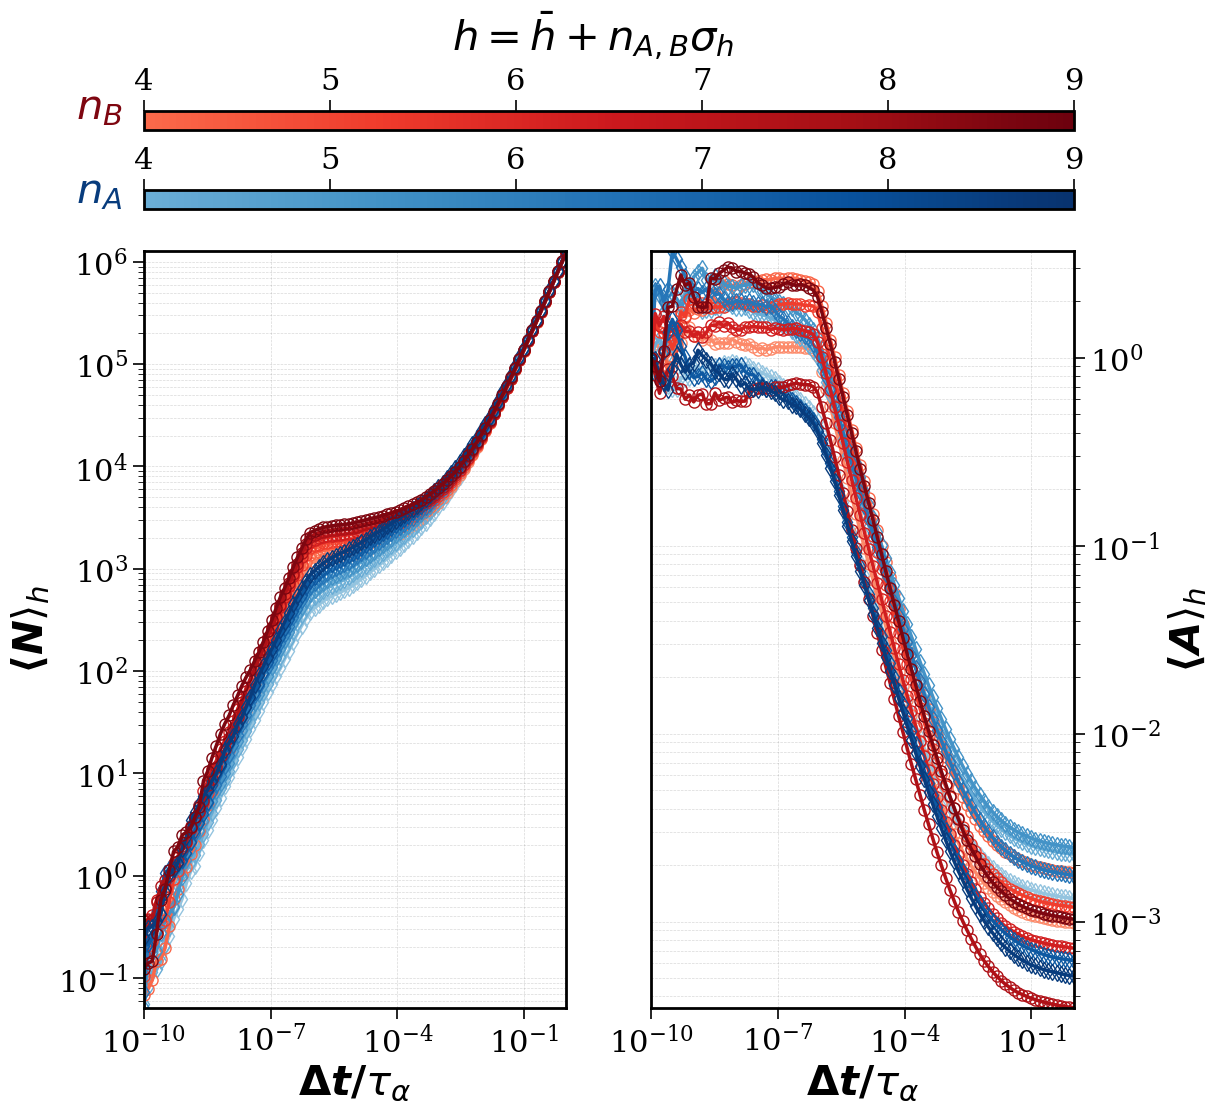

In [18]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Reds')
    colors_before = cmap_before(np.linspace(0.4, 0.95, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.4, 0.95, N_H))

    fig, axs = plt.subplots(1, 2, figsize=(12, 12), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0].plot(time_windows, mean_n_after[h], linestyle='-',
                    markersize=8, marker=r'd', fillstyle='none',
                    color=colors_after[i], label=rf'A: $h=\bar h+{n_std:.0f}\sigma_h$')

        axs[0].plot(time_windows, mean_n_before[h], linestyle='-',
                    markersize=8, fillstyle='none', marker='o',
                    color=colors_before[i], label=rf'B: $h=\bar h+{n_std:.0f}\sigma_h$')

        axs[1].plot(time_windows, normalized_mean_activity_after[h], linestyle='-',
                    marker=r'd', fillstyle='none', markersize=8,
                    color=colors_after[i])
        axs[1].plot(time_windows, normalized_mean_activity_before[h], linestyle='-', marker='o', fillstyle='none', color=colors_before[i],
                    markersize=8)

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[0].set_ylabel(r'$\boldsymbol{\langle N\rangle_h}$')
    axs[0].grid(True, alpha=0.3, which='both', ls='--')
    axs[0].set_xlim(min(time_windows), max(time_windows))
    axs[0].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                    max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
    axs[1].set_ylabel(r'$\boldsymbol{\langle A\rangle_h}$')
    axs[1].grid(True, alpha=0.3, which='both', ls='--')
    axs[1].set_xlim(min(time_windows), max(time_windows))
    axs[1].set_ylim(
        min([normalized_mean_activity_before[h].min() for h in HEIGHTS] + [normalized_mean_activity_after[h].min() for h
                                                                           in HEIGHTS]),
        max([normalized_mean_activity_before[h].max() for h in HEIGHTS] + [normalized_mean_activity_after[h].max() for h
                                                                           in HEIGHTS]))
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")

    # Create horizontal colorbars
    norm_before = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_before = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_before(np.linspace(0.5, 0.99, 256))), norm=norm_before)
    sm_before.set_array([])
    cbar_before = fig.colorbar(sm_before, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50,
                               location='top')

    norm_after = mcolors.Normalize(vmin=min(N_STD), vmax=max(N_STD))
    sm_after = cm.ScalarMappable(cmap=cm.colors.ListedColormap(cmap_after(np.linspace(0.5, 0.99, 256))), norm=norm_after)
    sm_after.set_array([])
    cbar_after = fig.colorbar(sm_after, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, aspect=50,
                              location='top')

    # Add text annotations
    fig.text(0.088, 0.79, r'$n_A$', va='center', ha='center', rotation=0, fontsize=30, color=colors_after[-1])
    fig.text(0.088, 0.86, r'$n_B$', va='center', ha='center', rotation=0, fontsize=30, color=colors_before[-1])
    fig.text(0.5, 0.92, r'$h = \bar{h} + n_{A,B}\sigma_h$', va='center', ha='center', rotation=0, fontsize=30,
             color='black')

    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'norm_activity_vs_time2.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'norm_activity_vs_time2.pkl'), 'wb') as f:
            pickle.dump(fig, f)

    plt.show()

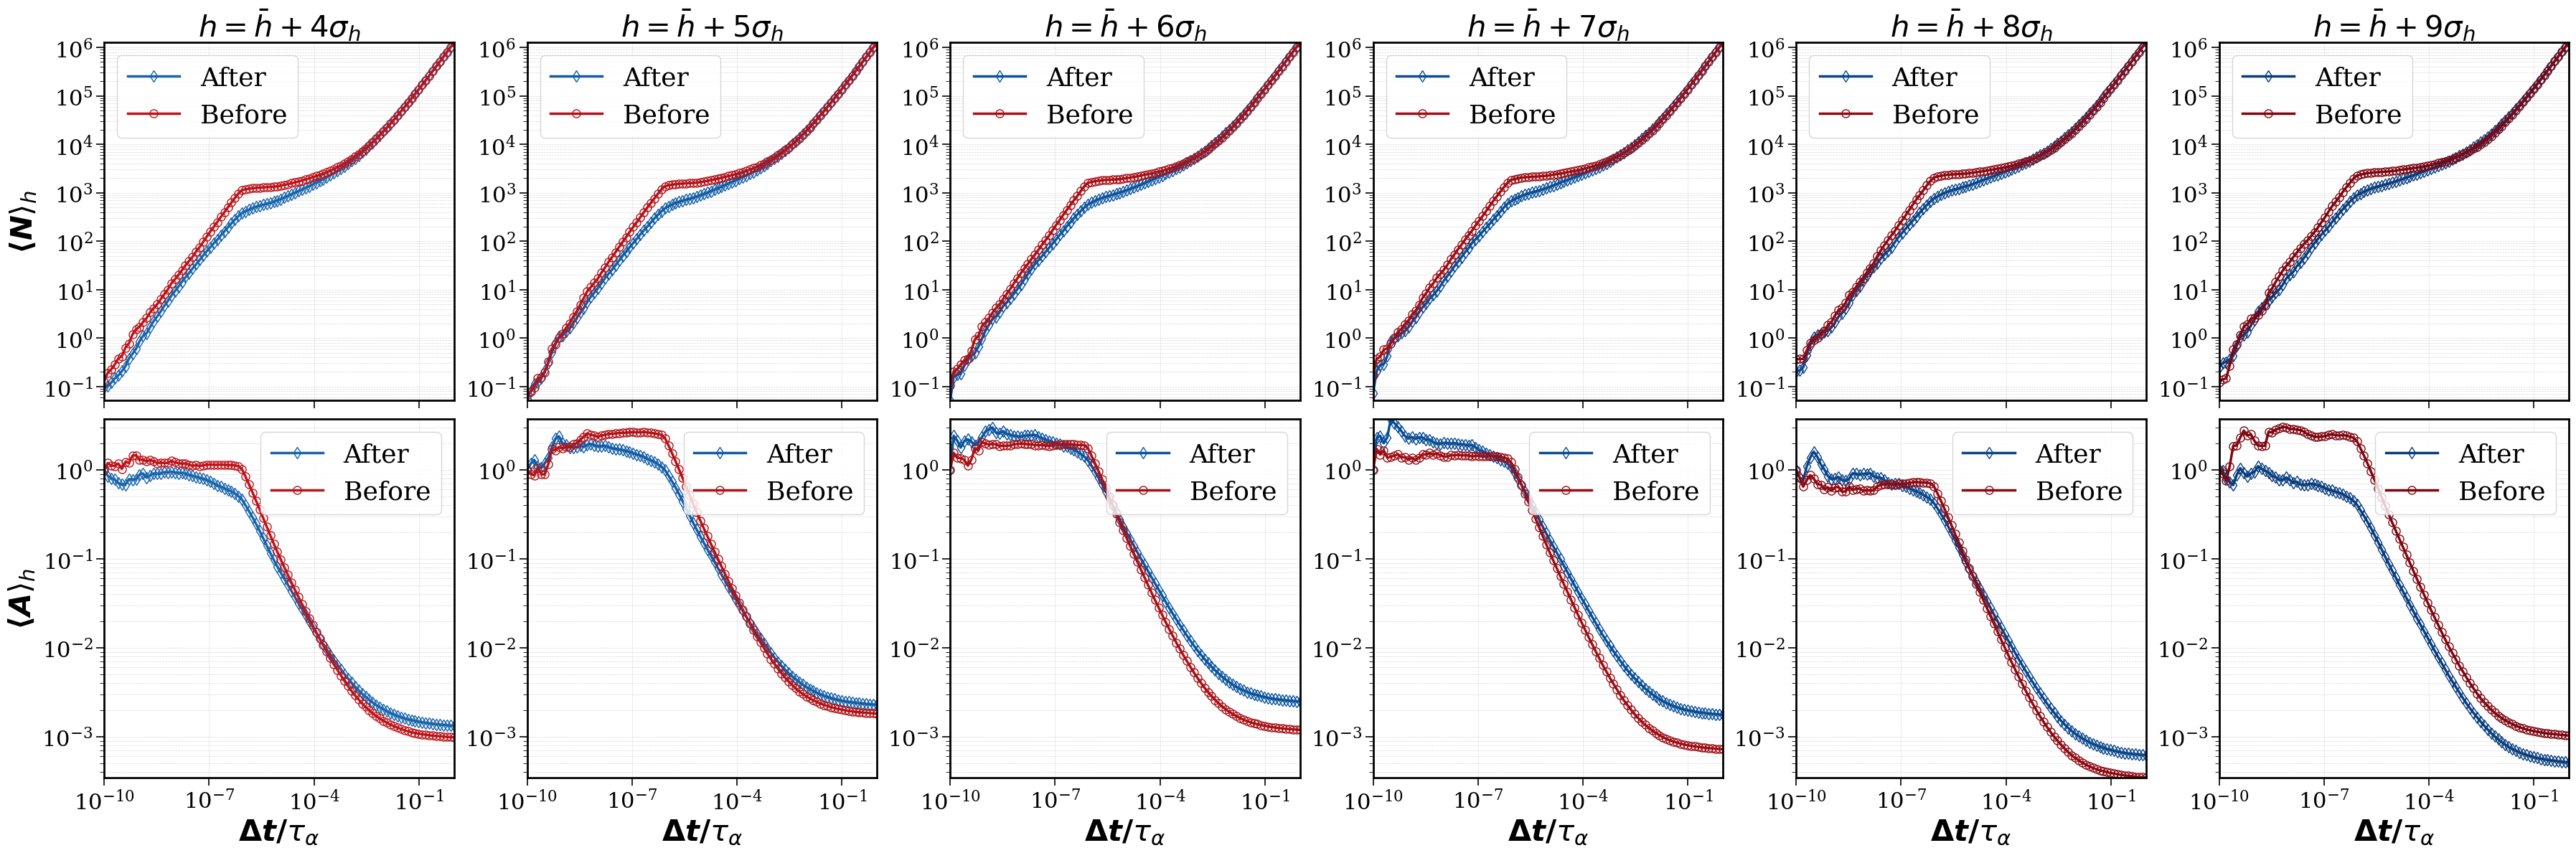

In [19]:
if COMPUTE_ACTIVITY_FOR_GIVEN_HEIGHTS:
    cmap_before = plt.get_cmap('Reds')
    colors_before = cmap_before(np.linspace(0.8, 0.95, N_H))
    cmap_after = plt.get_cmap('Blues')
    colors_after = cmap_after(np.linspace(0.8, 0.95, N_H))
    
    fig, axs = plt.subplots(2, N_H, figsize=(6*N_H, 12), sharex=True)
    for i, (h, n_std) in enumerate(zip(HEIGHTS, N_STD)):
        axs[0, i].plot(time_windows, mean_n_after[h], linestyle='-', markersize=8, fillstyle='none',
                    marker=r'd', color=colors_after[i], label='After')
        axs[0, i].plot(time_windows, mean_n_before[h], linestyle='-', markersize=8, fillstyle='none',
                    marker='o', color=colors_before[i], label='Before')
        axs[1, i].plot(time_windows, normalized_mean_activity_after[h], linestyle='-', marker=r'd', fillstyle='none',
                    color=colors_after[i], markersize=8, label='After')
        axs[1, i].plot(time_windows, normalized_mean_activity_before[h], linestyle='-', marker='o', color=colors_before[i],
                    markersize=8, fillstyle='none', label='Before')

        axs[0, i].set_xscale('log')
        axs[0, i].set_yscale('log')
        axs[0, i].set_title(rf'$h=\bar h+{n_std:.0f}\sigma_h$')
        axs[0, i].grid(True, alpha=0.3, which='both', ls='--')
        axs[0, i].legend(loc='upper left')
        axs[0, i].set_xlim(min(time_windows), max(time_windows))
        axs[0, i].set_ylim(min([mean_n_before[h].min() for h in HEIGHTS] + [mean_n_after[h].min() for h in HEIGHTS]),
                        max([mean_n_before[h].max() for h in HEIGHTS] + [mean_n_after[h].max() for h in HEIGHTS]))
        
        axs[1, i].set_xscale('log')
        axs[1, i].set_yscale('log')
        axs[1, i].legend(loc='upper right')
        axs[1, i].set_xlabel(r'$\boldsymbol{\Delta t/\tau_\alpha}$')
        axs[1, i].grid(True, alpha=0.3, which='both', ls='--')
        axs[1, i].set_xlim(min(time_windows), max(time_windows))
        axs[1, i].set_ylim(min([normalized_mean_activity_before[h].min() for h in HEIGHTS] 
                               + [normalized_mean_activity_after[h].min() for h in HEIGHTS]), 
                           max([normalized_mean_activity_before[h].max() for h in HEIGHTS] 
                               + [normalized_mean_activity_after[h].max() for h in HEIGHTS]))
        
    axs[0, 0].set_ylabel(r'$\boldsymbol{\langle N\rangle_h}$')
    axs[1, 0].set_ylabel(r'$\boldsymbol{\langle A\rangle_h}$')

    plt.tight_layout()
    
    if SAVE_PLOT:
        save_dir = os.path.join(FIGURE_DIR)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(os.path.join(save_dir, 'norm_activity_vs_time_all.pdf'), bbox_inches='tight')
        with open(os.path.join(save_dir, 'norm_activity_vs_time_all.pkl'), 'wb') as f:
            pickle.dump(fig, f)
    
    plt.show()